In [1]:
import os
import sys
import re
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from pathlib import Path

Get list of files for data

In [2]:
data_location = r'/media/mco143/2TB/OpenFOAM Simulations/Ebrahim_validation'

data_files = []
data_method = []

for path in Path(data_location).rglob('force.dat'):
    data_files.append(path)
    data_method.append(path.parts[-6])

data_files.sort()
data_method.sort()

['st0_05', 'st0_10', 'st0_25', 'st0_50', 'st0_75', 'st1_00', 'st1_25', 'st1_50', 'st2_50'] [PosixPath('/media/mco143/2TB/OpenFOAM Simulations/Ebrahim_validation/st0_05/backGround/postProcessing/forces_object/0/force.dat'), PosixPath('/media/mco143/2TB/OpenFOAM Simulations/Ebrahim_validation/st0_10/backGround/postProcessing/forces_object/0/force.dat'), PosixPath('/media/mco143/2TB/OpenFOAM Simulations/Ebrahim_validation/st0_25/backGround/postProcessing/forces_object/0/force.dat'), PosixPath('/media/mco143/2TB/OpenFOAM Simulations/Ebrahim_validation/st0_50/backGround/postProcessing/forces_object/0/force.dat'), PosixPath('/media/mco143/2TB/OpenFOAM Simulations/Ebrahim_validation/st0_75/backGround/postProcessing/forces_object/0/force.dat'), PosixPath('/media/mco143/2TB/OpenFOAM Simulations/Ebrahim_validation/st1_00/backGround/postProcessing/forces_object/0/force.dat'), PosixPath('/media/mco143/2TB/OpenFOAM Simulations/Ebrahim_validation/st1_25/backGround/postProcessing/forces_object/0/forc

Retrieve the data with an array of arrays for each parameter that's important.

Format of the data:

# Time (total_x total_y total_z)	(pressure_x pressure_y pressure_z)	(viscous_x viscous_y viscous_z)

In [3]:
def process_single_file(file_name, startTime = 0.1, endTime = 10.0):
    raw = []

    with open(file_name, 'r') as f:
        for line in f:
            tmp = [x.strip('(').strip(')') for x in line.split()]
            if len(tmp) == 0:
                continue
            elif tmp[0] == '#':
                continue
            else:
                if float(tmp[0]) < startTime:
                    continue
                elif float(tmp[0]) > endTime:
                    break
                else:
                    try:
                        raw.append([ float(i) for i in tmp ])
                    except:
                        print("could not convert string to float in line:")
                        print("\t" + line)
                        print("in file:")
                        print("\t" + file_name)

    raw = np.array(raw)

    return np.array([raw[:,0], raw[:,1], raw[:,2], raw[:,3], raw[:,4], raw[:,5], raw[:,6], raw[:,7], raw[:,8], raw[:,9]])

In [4]:
writer = pd.ExcelWriter('forceData.xlsx')

for i, path in enumerate(data_files):
    [time, total_x, total_y, total_z, pressure_x, pressure_y, pressure_z, viscous_x, viscous_y, viscous_z] = process_single_file(path, startTime=0.0, endTime=20.0)

    data_template = {'Time':time, 'total_x':total_x, 'total_y':total_y, 'total_z':total_z, 'pressure_x':pressure_x, 'pressure_y':pressure_y, 'pressure_z':pressure_z, 'viscous_x':viscous_x, 'viscous_y':viscous_y, 'viscous_z':viscous_z}

    mesh_df = pd.DataFrame(data_template)

    mesh_df.to_excel(writer, sheet_name=data_method[i], index=False)

writer.save()

In [5]:
dataBase = r'./forceData.xlsx'

number_cycles = 2
total_cycles = 3

time = []
total_x = []
period = []

density=998.2

xl = pd.ExcelFile(Path(dataBase))

data_names = xl.sheet_names

# gather data from excel sheet

for i, name in enumerate(data_names):
    df = pd.read_excel(Path(dataBase), sheet_name = name)
    cuttoff_time = df['Time'].values[-1]*(number_cycles/total_cycles)
    period.append(df['Time'].values[-1]/total_cycles)
    
    data = df[df['Time'] > cuttoff_time]
    time.append(data['Time'].values)
    total_x.append(data['total_x'].values/density)

In [6]:
### simple fliter function
def filterData(x, kernelLength = 11, kernelFunction = 'flat'):

    if len(x) < kernelLength:
        raise ValueError("kernel length > data")
    
    if not kernelFunction in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("kernel function available are: 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")
    
    # x = np.r_[x[kernelLength-1:0:-1], x, x[-2:-kernelLength-1:-1]]
    
    # flat corresponds to a moving average filter
    if kernelFunction == "flat":
        kernel = np.ones(kernelLength, 'd')
    else:
        kernel = eval('np.' + kernelFunction + '(kernelLength)')
    
    return np.convolve(kernel / kernel.sum(), x, mode='valid')

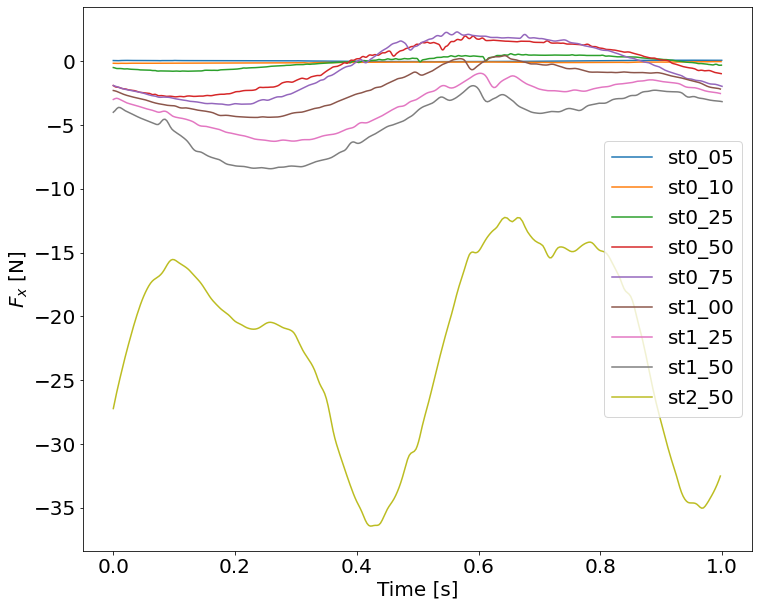

In [7]:
average = np.zeros(len(data_names))

plt.rcParams.update({'font.size':20})
fig1, ax1 = plt.subplots(figsize=(12,10))
for i, names in enumerate(data_names):
    filtered_force = filterData(total_x[i], kernelLength=11, kernelFunction='hanning')
    x = np.linspace(time[i][0], time[i][-1], len(filtered_force))
    filtered_force = np.interp(time[i], x, filtered_force)
    average[i] = np.mean(filtered_force)
    ax1.plot((time[i]-time[i][0])/period[i], filtered_force, label=data_names[i])

ax1.set_ylabel('$F_x$ [N]')
ax1.set_xlabel('Time [s]')
ax1.legend()

In [29]:
eb_data = np.array([0.1307,0.1039,-0.002619,-0.188966,-0.5590,-1.139,-1.8766,-2.850414,-8.68766])
strouhal = np.array([0.05, 0.1, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 2.5])
average_data = average*0.42

error = np.sqrt(np.sum(np.abs(average_data - eb_data))/len(eb_data))
print(error)

0.5849227177266804


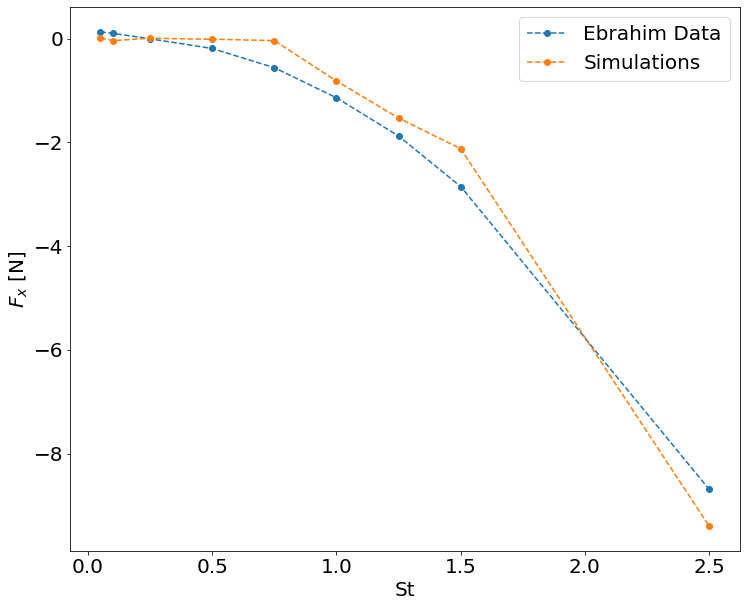

In [30]:
fig2, ax2 = plt.subplots(figsize=(12,10))
ax2.plot(strouhal, eb_data, 'o--', label='Ebrahim Data')
ax2.plot(strouhal, average_data, 'o--', label='Simulations')
ax2.set_ylabel('$F_x$ [N]')
ax2.set_xlabel('St')
ax2.legend()